In [1]:
import os
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from IPython import display
from tqdm import tqdm

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Conv2DTranspose, LeakyReLU, ReLU,
    BatchNormalization, Reshape, Activation, Flatten, Dropout
)

In [2]:
IMAGE_PHOTO_DIR = '/kaggle/input/gan-getting-started/photo_jpg'
image_filenames = []
print(os.listdir(IMAGE_PHOTO_DIR)[:10])

for dirname, _, filenames in os.walk(IMAGE_PHOTO_DIR):
    for filename in filenames:
        image_filenames.append(os.path.join(dirname, filename))
        
print(len(image_filenames), ' files loaded')

['fb97febc5f.jpg', 'c54c5368af.jpg', '4a06596662.jpg', '2629524a69.jpg', '5e64b64de8.jpg', 'ed34d8d7f3.jpg', '8eaf38146d.jpg', '21c2c68337.jpg', '74e1d0f495.jpg', '1b98321823.jpg']
7038  files loaded


In [3]:
BUFFER_SIZE = 7038
BATCH_SIZE = 16

def preprocess_jpg_image(image):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Preprocess images and create dataset
processed_jpg_photos = list(map(preprocess_jpg_image, image_filenames))
dataset = tf.data.Dataset.from_tensor_slices(processed_jpg_photos)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
    
print(len(dataset), ' image dataset created')

440  image dataset created


In [4]:
def get_latest_checkpoint(directory):
    # Define the pattern for the filenames
    pattern = re.compile(r'ckpt-(\d+)\.weights\.h5')
    
    latest_file = None
    latest_index = -1

    try:
        # List all files in the directory
        for filename in os.listdir(directory):
            match = pattern.match(filename)
            if match:
                # Extract the number from the filename
                index = int(match.group(1))
                if index > latest_index:
                    latest_index = index
                    latest_file = filename

    except FileNotFoundError:
        return latest_file
    
    return latest_file

In [5]:
GEN_CHECKPOINT_DIR = "generator_checkpoints"
DISC_CHECKPOINT_DIR = "discriminator_checkpoints"
CHECKPOINT_PREFIX = 'ckpt'

os.makedirs(GEN_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DISC_CHECKPOINT_DIR, exist_ok=True)

def create_checkpoint(epoch, directory, model):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    checkpoint_path = os.path.join(directory, f'{CHECKPOINT_PREFIX}-{epoch}.weights.h5')

    print(f"{checkpoint_path} created")
    model.save_weights(checkpoint_path)

In [6]:
def create_generator():
    noise_input = Input(shape=(100,))

    # Dense layer to reshape into a 16x16x512 tensor
    x = Dense(16 * 16 * 512, use_bias=False)(noise_input)  # Use bias=False for BatchNormalization
    x = Reshape((16, 16, 512))(x)
    
    # Upsampling blocks
    x = Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # 32x32x256
    
    x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # 64x64x128
    
    x = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # 128x128x64
    
    x = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # 256x256x32
    
    output = Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh')(x)  # Output layer

    return tf.keras.Model(inputs=noise_input, outputs=output)

generator_model = create_generator()
generator_weights = get_latest_checkpoint(GEN_CHECKPOINT_DIR)

if generator_weights:
    generator_model.load_weights(generator_weights)
    print(f"Generator loaded from - {generator_weights}")

In [7]:
def create_discriminator():
    image_input = Input(shape=(256, 256, 3))

    # First convolutional layer
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(image_input)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)

    # Second convolutional layer
    x = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)

    # Third convolutional layer
    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)

    # Fourth convolutional layer
    x = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(512)(x)  # Reduced number of units
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.3)(x)  # Adjust dropout rate for regularization

    # Output layer
    output = Dense(1, activation='sigmoid')(x)  # Probability of being real

    return tf.keras.Model(inputs=image_input, outputs=output)

discriminator_model = create_discriminator()
discriminator_weights = get_latest_checkpoint(DISC_CHECKPOINT_DIR)

if discriminator_weights:
    discriminator_model.load_weights(discriminator_weights)
    print(f"Discriminator loaded from - {discriminator_weights}")

I0000 00:00:1725602032.087132     100 service.cc:145] XLA service 0x7ecf24003ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725602032.087206     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1725602033.457845     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


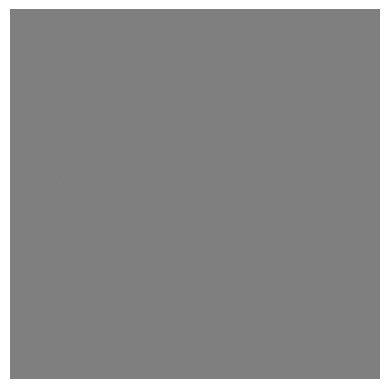

In [8]:
def generate_image():
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, 100))

    # Generate an image from the noise
    return generator_model.predict(noise)

def show_generated_image(image):
    image = ((image * 127.5) + 127.5).reshape((256, 256, 3))
    image = image.astype(np.uint8)
    
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
show_generated_image(generate_image())

In [9]:
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
NOISE_DIM = 100

@tf.function
def train_step(generator, discriminator, images):
    # Generate random noise
    noise = tf.random.normal([images.shape[0], NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from the noise
        generated_images = generator(noise, training=True)

        # Discriminate between real and generated images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

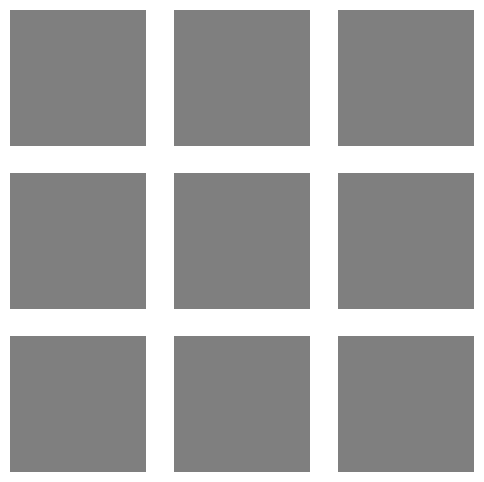

In [11]:
def generate_and_save_images(epoch=1, num_samples=9, noise_dim=NOISE_DIM, save=True):
    # Create directory for saving images if it doesn't exist
    if not os.path.exists('epoch_images'):
        os.makedirs('epoch_images')
    
    # Generate noise
    noise = tf.random.normal([num_samples, noise_dim])  # Shape: (9, 100)
    
    # Generate images using the generator model
    predictions = generator_model(noise, training=False)
#     predictions = (predictions * 127.5) + 127.5
    predictions = (predictions + 1) / 2
    
    # Create a figure for saving images
    num_cols = 3
    num_rows = 3
    
    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))
    
    for i in range(num_samples):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')
    
    # Save the figure
    if save:
        plt.savefig(os.path.join('epoch_images', f"img_epoch_{epoch:04d}.png"))
    plt.show()

# Example usage
generate_and_save_images(save=False)

In [62]:
EPOCHS = 500

def train(dataset, epochs, start=0):
    generate_and_save_images(epoch=start, save=True)
    create_checkpoint(start, GEN_CHECKPOINT_DIR, generator_model)
    create_checkpoint(start, DISC_CHECKPOINT_DIR, discriminator_model)
    
    for epoch in range(start+1, epochs):
        start = time.time()
        
        for image_batch in tqdm(dataset):
            # Train the model with the current batch
            train_step(generator_model, discriminator_model, image_batch)

        display.clear_output(wait=True)
        
        # Clear the output and generate images every epoch
        generate_and_save_images(epoch=epoch+1, save=True)
    
        # Save the model checkpoint every 10 epochs
        if (epoch + 1) % 5 == 0:
            create_checkpoint(epoch + 1, GEN_CHECKPOINT_DIR, generator_model)
            create_checkpoint(epoch + 1, DISC_CHECKPOINT_DIR, discriminator_model)
            
            if (epoch + 1) % 40 == 0:
                print(f"{epoch = }")
                break
                
        print(f"Epoch {epoch + 1}: {time.time() - start} seconds")

    create_checkpoint(epochs, GEN_CHECKPOINT_DIR, generator_model)
    create_checkpoint(epochs, DISC_CHECKPOINT_DIR, discriminator_model)
        
    # Generate images at the end of training
    generate_and_save_images(epoch=epochs, save=True)

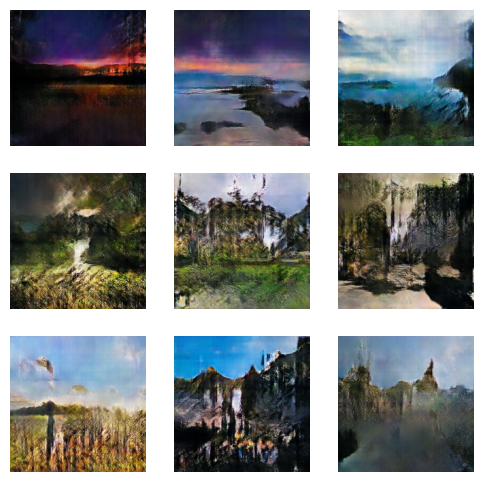

generator_checkpoints/ckpt-120.weights.h5 created
discriminator_checkpoints/ckpt-120.weights.h5 created
epoch = 119
generator_checkpoints/ckpt-500.weights.h5 created
discriminator_checkpoints/ckpt-500.weights.h5 created


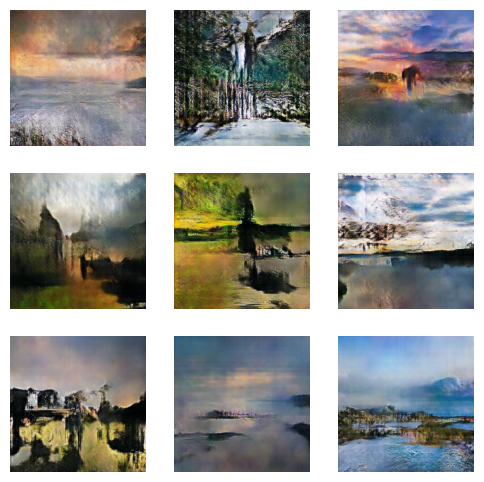

In [63]:
train(dataset, EPOCHS, start=80)

In [69]:
def get_latest_checkpoints(directory, num_files=1):
    pattern = re.compile(r'ckpt-(\d+)\.weights\.h5')
    
    checkpoints = []

    try:
        for filename in os.listdir(directory):
            match = pattern.match(filename)
            if match:
                index = int(match.group(1))
                checkpoints.append((index, filename))

        checkpoints.sort(reverse=True, key=lambda x: x[0])
        latest_files = [filename for _, filename in checkpoints[:num_files]]
    
    except FileNotFoundError:
        return []

    return latest_files

def delete_old_checkpoints(directory, keep_count=1):
    try:
        # Get the latest checkpoints to keep
        keep_files = get_latest_checkpoints(directory, num_files=keep_count)

        # List all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            
            # If the file is not in the list of files to keep, delete it
            if filename not in keep_files:
                if os.path.isfile(file_path):
                    # os.remove(file_path)
                    print(f"Deleted: {file_path}")

    except FileNotFoundError:
        print(f"Directory not found: {directory}")
    except PermissionError as e:
        print(f"Permission error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [70]:
# num_files = 9
# print('\n'.join(get_latest_checkpoints(GEN_CHECKPOINT_DIR, num_files)))
# print('\n'.join(get_latest_checkpoints(DISC_CHECKPOINT_DIR, num_files)))

# delete_old_checkpoints(GEN_CHECKPOINT_DIR, keep_count=num_files)
# delete_old_checkpoints(DISC_CHECKPOINT_DIR, keep_count=num_files)

Deleted: generator_checkpoints/ckpt-60.weights.h5
Deleted: generator_checkpoints/ckpt-80.weights.h5
Deleted: generator_checkpoints/ckpt-65.weights.h5
Deleted: generator_checkpoints/ckpt-45.weights.h5
Deleted: generator_checkpoints/ckpt-55.weights.h5
Deleted: generator_checkpoints/ckpt-50.weights.h5
Deleted: generator_checkpoints/ckpt-70.weights.h5
Deleted: generator_checkpoints/ckpt-75.weights.h5
Deleted: generator_checkpoints/ckpt-40.weights.h5
Deleted: discriminator_checkpoints/ckpt-60.weights.h5
Deleted: discriminator_checkpoints/ckpt-80.weights.h5
Deleted: discriminator_checkpoints/ckpt-65.weights.h5
Deleted: discriminator_checkpoints/ckpt-45.weights.h5
Deleted: discriminator_checkpoints/ckpt-55.weights.h5
Deleted: discriminator_checkpoints/ckpt-50.weights.h5
Deleted: discriminator_checkpoints/ckpt-70.weights.h5
Deleted: discriminator_checkpoints/ckpt-75.weights.h5
Deleted: discriminator_checkpoints/ckpt-40.weights.h5


In [71]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/epoch_images/ (stored 0%)
  adding: kaggle/working/epoch_images/img_epoch_0108.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0087.png (deflated 0%)
  adding: kaggle/working/epoch_images/img_epoch_0031.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0046.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0056.png (deflated 0%)
  adding: kaggle/working/epoch_images/img_epoch_0035.png (deflated 0%)
  adding: kaggle/working/epoch_images/img_epoch_0055.png (deflated 0%)
  adding: kaggle/working/epoch_images/img_epoch_0023.png (deflated 0%)
  adding: kaggle/working/epoch_images/img_epoch_0022.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0028.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0115.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0034.png (deflated 1%)
  adding: kaggle/working/epoch_images/img_epoch_0065.png (d

In [72]:
from IPython.display import FileLink
FileLink("file.zip")

/kaggle/working/file.zip